In [49]:
import networkx as nx
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import urllib
import zipfile
import io
import csv
from mpl_toolkits.mplot3d.axes3d import Axes3D, get_test_data


In [50]:
def get_A(G):
    return nx.linalg.graphmatrix.adjacency_matrix(G).todense()

def distance(G, source, target):
    return nx.shortest_path_length(G, source=source, target=target)


In [51]:
def generate_simplex(n):
    G = nx.Graph()
    for i in range(n):
        for j in range(i+1,n):
            G.add_edge(i,j)
    return G

def generate_regular(n, d, connected=True):
    G = nx.Graph()
    possible_edges = []
    for i in range(n):
        G.add_node(i)
        possible_edges += [(i, j) for j in range(i+1, n)]
    num_edges = n*d/2
    assert int(num_edges) == num_edges, "Graph with {} nodes and {} degree everywhere is impossible".format(n, d)
    assert num_edges <= len(possible_edges)
    for i in range(int(num_edges)):
        edge = random.choice(possible_edges)
        while not all([G.degree(node) < d for node in list(edge)]):
            try:
                possible_edges.remove(edge)
                edge = random.choice(possible_edges)
            except IndexError:
#                 print([G.degree(node) for node in edge])
#                 print("AHH")
#                 nx.draw(G, with_labels=True, font_weight='bold')
#                 print("AHH")
                return generate_regular(n,d)

        G.add_edge(*edge)
        possible_edges.remove(edge)
    if connected:
        if not nx.is_connected(G):
            return generate_regular(n, d, connected=connected)
    return G

def generate_bipartite(n1, n2, p):
    unconnected = True
    while unconnected:
        G = nx.bipartite.random_graph(n1, n2, p)
        unconnected = not nx.is_connected(G)
    return G

def rand(n,p):
    g = nx.gnp_random_graph(n, p)
    while not nx.is_connected(g):
        g = nx.gnp_random_graph(n, p)
    return g


#     G = nx.Graph()
#     for i in range(n1):
#         possible_edges += [(i, j) for j in range(i+1, n)]
#         for j in range(n1+1,n2):
#             if np.random.random() < p:
#                 G.add_edge(i,j)
#     connectivity?!!?!



In [52]:
def degree_centralities(G):
    n = len(G.nodes)
    cs = [G.degree(node) for node in G.nodes]
    Cs = [ci/n for ci in cs]
    return Cs

def eigen_centralities(G):
    n = len(G.nodes)
    A = get_A(G)
    if np.all(A.T == A):
        vals, vecs = scipy.linalg.eigh(A, eigvals=(n-1,n-1))
        print("symmetric")
        assert len(vecs.T) == 1, "Multiple vecs {}, shape is {}".format(vecs.T, vecs.shape)
        max_v = vecs.T[0]
    else:
        print("nonsymmetric")
        vals, vecs = np.linalg.eig(A)
        max_v = vecs[np.argmax(vals)]
    cs = max_v
    Cs = max_v / sum(max_v)
    return list(Cs)

def alpha_centralities(G, alpha):
    n = len(G.nodes)
    M = np.identity(n) - alpha * get_A(G).T
    inv = np.linalg.inv(M)
    cs = np.dot(inv, np.ones(n))
    Cs = cs / np.sum(cs)
    return Cs

def closeness_centralities(G):
    n = len(G.nodes)
    cs = [1/sum([distance(G, node, v) for v in G.nodes]) for node in G.nodes]
    Cs = [(n-1) * ci for ci in cs]
    return Cs

def betweenness_centralities(G):
    n = len(G.nodes)
    cs = [0 for _ in range(n)]
    for i in G.nodes:
        for j in G.nodes:
            if i == j:
                continue
            paths = nx.all_shortest_paths(G, i, j)
            paths = [path for path in paths]
            num_paths = len(paths)
            for idx,v in enumerate(G.nodes):
                if v == i or v == j:
                    continue
                cs[idx] += sum([v in path for path in paths]) / num_paths
    Cs = [ci/((n-1)*(n-2)) for ci in cs]
    return Cs


[[0.17607973 0.12956811 0.06644518 0.09302326 0.15780731 0.2192691
  0.15780731]]


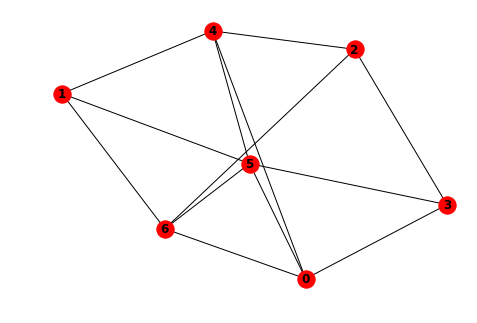

In [53]:
G = rand(7,0.7)#generate_regular(10,3)
nx.draw(G, with_labels=True, font_weight='bold')
print(alpha_centralities(G, 0.5))
# print(type(get_A(G)))
# print(G.adjacency())
# print(nx.linalg.graphmatrix.adjacency_matrix(G).todense())

# G = generate_simplex(7)
# nx.draw(G, with_labels=True, font_weight='bold')
# G.degree(0)

In [54]:
graphs = [generate_simplex(i) for i in range(1,6)] + [generate_regular(10,3), generate_regular(10,2)]
centralities = {"degree": degree_centralities,
                "eigen": eigen_centralities,
#                 "alpha": alpha_centralities,
                "closeness": closeness_centralities,
                "betweenness": betweenness_centralities}    

def test(G, centralities=centralities, with_alpha=True, draw_graph=True, lines=True):
    ncols, nrows, idx = 1, 1, 1
    if with_alpha:
        nrows += 1
    if draw_graph:
        nrows += 1

    fig = plt.figure(figsize=(4,4*nrows))

    if draw_graph:
        plt.subplot(nrows, ncols, idx)
        idx += 1
        nx.draw(G, with_labels=True, font_weight="bold")

    plt.subplot(nrows, ncols, idx)
    idx += 1

    data = {}
    for name, measure in centralities.items():
        data[name] = measure(G)
    colors = cm.rainbow(np.linspace(0, 1, len(data)))

    for i,name in enumerate(data):
#         print(name, data[name], list(G.nodes))
        plt.scatter(list(G.nodes), data[name], color=colors[i], label=name)
        if lines:
            plt.plot(list(G.nodes), data[name], color=colors[i])
    plt.legend(loc="best")

    if with_alpha:
        ax = fig.add_subplot(nrows, ncols, idx)#, projection='3d')
        idx += 1

        x = list(G.nodes)
        y = np.linspace(0, 1, 20)
        X, Y = np.meshgrid(x, y)
        seqs = [alpha_centralities(G, alpha+0.001) for alpha in y]
        Z = np.concatenate(seqs)
#         print("X", X, "\n\nY", Y, "\n\nZ", Z)
#         ax.plot_wireframe(X,Y,Z)
        ax.imshow(Z, vmin=-1,vmax=1)#, extent=(0, len(x), max(y), min(y)), interpolation='nearest', cmap=cm.gist_rainbow)
        plt.xlabel("node")
        plt.ylabel("alpha*20")

    
    
    
    

In [73]:
example_edges = [(1,2),(2,3),(3,4),(4,5),(5,1),(3,6),(6,7),(7,8),(8,3),(7,9),(9,10),(10,11),(11,3),(10,12),(12,8),(12,13),(13,14),(14,5),(5,15),(13,16),(13,17),(10,18)]
example_g = nx.Graph()
example_g.add_edges_from(example_edges)

def make_primate_graph():
    resp = urllib.request.urlopen("http://www.complex-networks.net/datasets/primates.zip")
    zipped = zipfile.ZipFile(io.BytesIO(resp.read()))
    primate_data = zipped.open('primates/primates.net').read()
    rows = csv.reader(io.BytesIO(primate_data), delimiter=' ', newline='') # pd.read_csv
    G = nx.Graph()
    for row in rows:
        print(type(row),row)
        G.add_edge(v1, v2)
    return G

def generate_test_graphs():
    G = nx.Graph()
    G.add_edges_from(example_edges)
    graphs = {"simplex": generate_simplex(5),
             "regular": generate_regular(10,3),
             "bipartite": generate_bipartite(4,5,0.6),
             "random": rand(5,0.5),
             "example": G}

symmetric
symmetric
symmetric
symmetric
symmetric


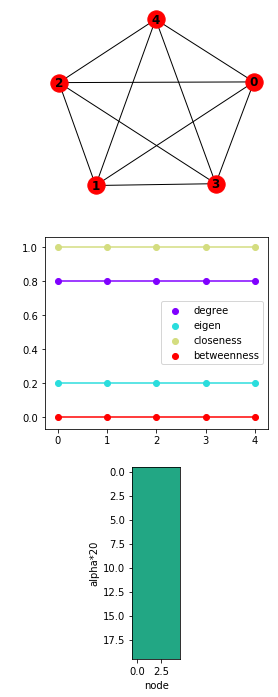

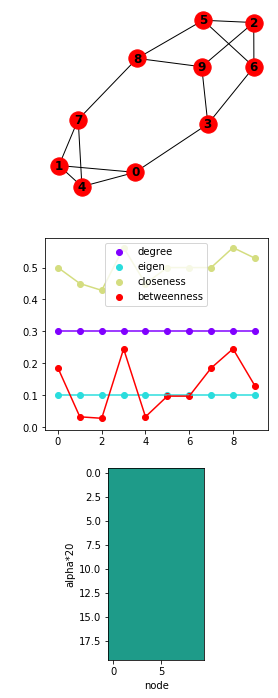

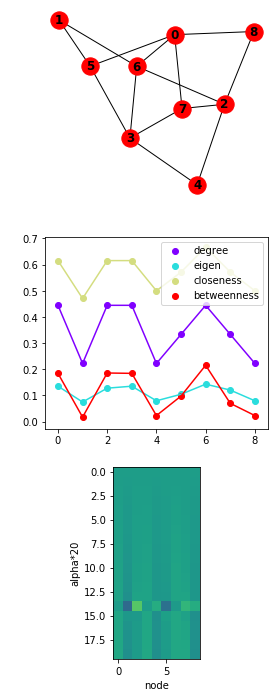

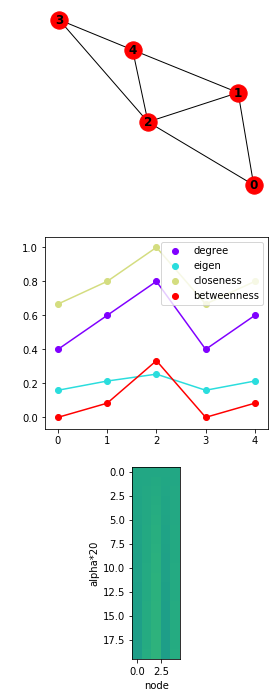

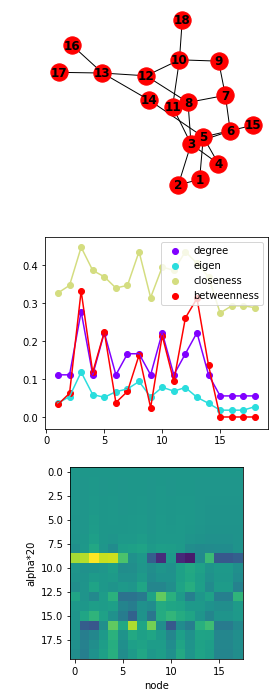

In [74]:
test(generate_simplex(5))
test(generate_regular(10,3))
test(generate_bipartite(4,5,0.6))
test(rand(5,0.5))
test(example_g)

In [75]:
make_primate_graph()

TypeError: 'newline' is an invalid keyword argument for this function